In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample
from pyro.infer import SVI, TraceMeanField_ELBO, Trace_ELBO
import pyro.optim as optim
from pyro.infer.autoguide import AutoMultivariateNormal, AutoDiagonalNormal
import supereeg as se
import numpy as np
import os
import pyro.distributions as dist
from math import prod
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm
from scipy.io import loadmat

matplotlib.use('nbAgg')
%matplotlib inline

In [2]:
if os.path.exists('sample.bo'):
    bo = se.load('sample.bo')
else:
    bo = se.simulate_bo(1,9919)
    bo.save('sample.bo')

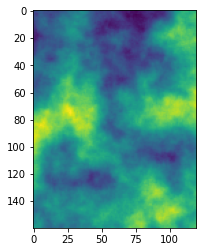

In [8]:
mat = loadmat('gmrf1.mat', squeeze_me=True)
img = mat['GMRFsample']
# img = np.nan_to_num(img,nan=-0)
plt.imshow(img)

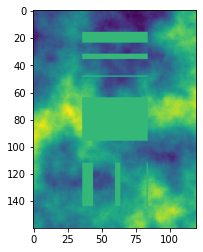

In [9]:
def get_toy_mask(sz):
    mask = np.ones(sz)
    mask[int(.4*sz[0]):int(.6*sz[0]),int(.3*sz[1]):int(.7*sz[1])] = 0
    mask[int(.7*sz[0]):int(.9*sz[0]),int(.3*sz[1]):int(.3*sz[1])+8] = 0
    mask[int(.7*sz[0]):int(.9*sz[0]),int(.5*sz[1]):int(.5*sz[1])+4] = 0
    mask[int(.7*sz[0]):int(.9*sz[0]),int(.7*sz[1])-1:int(.7*sz[1])] = 0
    mask[int(.1*sz[0]):int(.1*sz[0]+8),int(.3*sz[1]):int(.7*sz[1])] = 0
    mask[int(.2*sz[0]):int(.2*sz[0]+4),int(.3*sz[1]):int(.7*sz[1])] = 0
    mask[int(.3*sz[0]):int(.3*sz[0]+1),int(.3*sz[1]):int(.7*sz[1])] = 0
    return mask

mask = get_toy_mask(img.shape)
img = img * mask
plt.imshow(img)

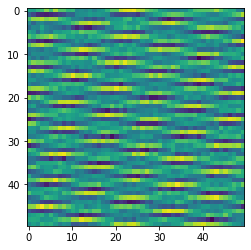

In [59]:
mat = np.arange(50*50).reshape(50,50)
img = np.sin(mat/5)
img = img * np.cos(mat/2).T + np.random.randn(50,50)/10
og_img = img
mask = np.ones(mat.shape)
mask[20:40,10:20] = 0
plt.imshow(img)

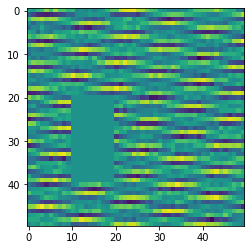

In [60]:
img = img * mask
img = torch.tensor(img).float()
mask = torch.tensor(mask).float()
plt.imshow(img)

In [7]:
pyro.enable_validation(True)
pyro.set_rng_seed(1)

In [ ]:
"""
Finds the solution to a linear system with symmetric positive definite A
using conjugate gradient
"""
def cg(A, b, x, tol):
    r = b - np.matmul(A, x)         # residual vector
    delta = np.matmul(r.T, r)       # inner product of residual with  itself
    bdelta = np.matmul(b.T, b)      # inner product of b with itself
    p = r                           # search direction
    while delta > tol**2 * bdelta:
        s = np.matmul(A, p)
        alpha = delta / np.matmul(p.T, s)   # updating step size
        x = x + alpha * p                   # updating x in iterative step
        r = r - alpha * s                   # updating residual
        delta_new = np.matmul(r.T, r)
        p = r + delta_new / delta * p       # updating search direction
        delta = delta_new

    return x

In [11]:
#TODO fix this idiotic nested class structure
class ConstrainedFilterPart(PyroModule):
    def __init__(self, idx, a0=2., f0=-0.1, g0=0.):
        super(ConstrainedFilterPart, self).__init__()
#         a0 = pyro.sample('a0_'+idx, dist.Normal(torch.tensor(a0, dtype=torch.float32), 0.4))
#         f0 = pyro.sample('f0_'+idx, dist.Normal(torch.tensor(f0, dtype=torch.float32), 0.4))
#         g0 = pyro.sample('g0_'+idx, dist.Normal(torch.tensor(g0, dtype=torch.float32), 0.4))
        a0 = pyro.param('a0_'+idx, torch.tensor(a0))
        f0 = pyro.param('f0_'+idx, torch.tensor(f0))
        g0 = pyro.param('g0_'+idx, torch.tensor(g0))
        self.a0 = a0; self.f0 = f0; self.g0 = g0
        a = F.softplus(a0)
        f = a / 2.0 * torch.tanh(f0)
        g = torch.exp(g0)
        b = f * torch.sqrt(g)
        c = f / torch.sqrt(g)
        self.filter = torch.stack([c,a,b])
        self.cuda()
    
    def get_filter(self):
        return self.filter

class Layer(PyroModule):
    
    ''' alpha is the weight learned for PReLU '''
    def __init__(self, idx, alpha=1., bias=0.01):
        super(Layer, self).__init__()
        self.fpart1 = ConstrainedFilterPart(idx + '0')
        self.fpart2 = ConstrainedFilterPart(idx + '1')
        f1 = self.fpart1.get_filter()
        f2 = self.fpart2.get_filter()
        zeros = torch.tensor([0.,0.,0.])
        f1 = torch.stack([zeros, f1, zeros])
        f2 = torch.stack([zeros, f2, zeros])
        self.filter = f1 + f2.T
#         self.alpha = pyro.sample('alpha_'+idx, dist.Normal(torch.tensor(alpha, dtype=torch.float32), 0.4))
        self.alpha = pyro.param('alpha_'+idx, torch.tensor(alpha))
        self.bias = pyro.param('bias_'+idx, torch.tensor(bias))
#         self.bias = pyro.param('bias_'+idx, torch.full([50,50],bias))
    
    def get_filter(self):
        return self.filter
    
    def get_alpha(self):
        return self.alpha
    
    def get_bias(self):
        return self.bias
        

class CNN(PyroModule):
    '''CNN with constrained filter to ensure Q SPD'''
    
    def __init__(self, nlayers):
        super(CNN, self).__init__()
        self.nlayers = nlayers
        self.layers = nn.ModuleList([Layer(str(i)) for i in range(nlayers)])
    
    def forward(self, x0):
        x = x0
        if x.dim() == 2:
            x = x[None,None,:]
            
        for i in range(self.nlayers):
            filt = self.layers[i].get_filter()[None,None,:]#.cuda()
            a = F.conv2d(x, filt, padding=1) + self.layers[i].get_bias()#.cuda()
            x = F.prelu(a, self.layers[i].get_alpha())
        
        return x

In [56]:
# def model(img, mask, nlayers=3):
#     eye = torch.eye(*img.shape)
#     zeros = torch.zeros(img.shape)
#     scale = torch.tril(F.softplus(pyro.sample('scale', dist.MultivariateNormal(zeros, eye).to_event(1))))
#     x = pyro.sample('x', dist.MultivariateNormal(img, scale_tril=scale).to_event(1))
# #     x = pyro.sample('x', dist.MultivariateNormal(torch.zeros(img.shape), 0.01*torch.eye(*img.shape)).to_event(1))
#     net = CNN(nlayers)
#     z = net(x)
#     pyro.sample('z', dist.MultivariateNormal(z, 0.01*eye).to_event(1), obs=img)
# img = img.cuda()
# mask = mask.cuda()

def model(img, mask, nlayers=3):
    eye = torch.eye(*img.shape)
    zeros = torch.zeros(img.shape)
    scale = torch.tril(F.softplus(pyro.sample('scale', dist.MultivariateNormal(zeros, eye).to_event(1))))
    x = pyro.sample('x', dist.MultivariateNormal(img, scale_tril=scale).to_event(1))
    net = CNN(nlayers)
    z = net(x) * mask
    pyro.sample('z', dist.MultivariateNormal(z, 0.01*eye).to_event(1), obs=img)
    
def model(img, mask, nlayers=3):
    eye = torch.eye(*img.shape)
    zeros = torch.zeros(img.shape)
    scale = torch.tril(F.softplus(pyro.sample('scale', dist.MultivariateNormal(zeros, eye).to_event(1))))
    x = pyro.sample('x', dist.MultivariateNormal(img, scale_tril=scale).to_event(1))
    net = CNN(nlayers)
    z = net(x) * mask
    pyro.sample('z', dist.MultivariateNormal(z, 0.01*eye).to_event(1), obs=img)
    
# def model(img, mask, nlayers=3):
#     stdnorm = dist.Normal(torch.tensor(0.), torch.tensor(1.)).expand([prod(img.shape)]).to_event(1)
#     scale_vec = pyro.sample('scale', stdnorm)
#     scale = torch.diag(F.softplus(scale_vec))
#     x = pyro.sample('x', dist.MultivariateNormal(img.reshape(-1), scale_tril=scale))
#     net = CNN(nlayers)
#     z = net(x.reshape(img.shape)) * mask
#     pyro.sample('z', dist.MultivariateNormal(z.reshape(-1), scale_tril=scale), obs=img.reshape(-1))

# def model(img, nlayers=3):
#     scale = F.softplus(pyro.sample('scale', dist.Normal(torch.tensor(0.), torch.tensor(1.))))
#     sigma = scale * torch.eye(*img.shape)
#     x = pyro.sample('x', dist.MultivariateNormal(torch.zeros(img.shape), sigma).to_event(1))
#     net = CNN(nlayers)
#     z = net(x)
#     pyro.sample('z', dist.MultivariateNormal(img, torch.eye(*img.shape)).to_event(1), obs=z)

# def model(img, mask, nlayers=3):
#     scale_dist = dist.Normal(torch.tensor(0.01),torch.tensor(0.005)); eps = 1e-6
#     lat_s = torch.abs(pyro.sample('latent_scale', scale_dist)) + eps
#     eye = torch.eye(*img.shape)
#     x = pyro.sample('x', dist.MultivariateNormal(torch.zeros(img.shape), lat_s*eye).to_event(1))
#     net = CNN(nlayers)
#     z = net(x) * mask
#     img_s = torch.abs(pyro.sample('img_scale', scale_dist)) + eps
#     zl = pyro.sample('z', dist.MultivariateNormal(img, img_s*eye).to_event(1), obs=z)


In [57]:
def guide(img, nlayers=3):
#     sigma = pyro.param('sigma', )
    x = pyro.sample('x', dist.MultivariateNormal(img, 0.1*torch.eye(*img.shape)).to_event(1))
    net = CNN(nlayers)
    z = net(x)

guide = AutoDiagonalNormal(model)
opt = optim.Adam({})#{'lr': 0.01})
svi = SVI(model, guide, opt, loss=Trace_ELBO())

In [81]:
# pyro.clear_param_store()
n_steps = 20000
# do gradient steps
pbar = tqdm(range(n_steps))
for i, step in enumerate(pbar):
    loss = svi.step(img, mask)
    pbar.set_postfix({'Loss':loss})

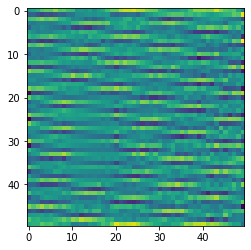

In [83]:
post_mean = pyro.param('AutoDiagonalNormal.loc')[-2500:].reshape([50,50]).detach().numpy()
plt.imshow(post_mean) 

In [86]:
list(pyro.get_param_store().items())
pyro.param('AutoDiagonalNormal.loc').shape

torch.Size([5000])

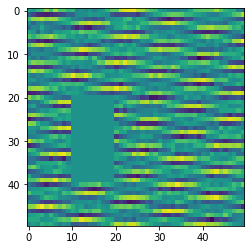

In [84]:
plt.imshow(img)

In [15]:
# print(pyro.param('AutoDiagonalNormal.loc').shape)
# [-21:]
nlayers = 3

/home/tudor/anaconda3/envs/supereeg_env/lib/python3.8/site-packages/pyro/primitives.py:85: RuntimeWarning: trying to observe a value outside of inference at z
  warnings.warn("trying to observe a value outside of inference at " + name,


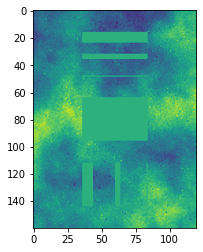

In [20]:
eye = torch.eye(prod(img.shape))
zeros = torch.zeros(prod(img.shape))
scale_vec = pyro.sample('scale', dist.MultivariateNormal(zeros, eye))
scale = torch.diag(F.softplus(scale_vec))
x = pyro.sample('x', dist.MultivariateNormal(img.reshape(-1), scale_tril=scale))
net = CNN(nlayers)
z = net(x.reshape(img.shape)) * mask
pyro.sample('z', dist.MultivariateNormal(z.reshape(-1), scale_tril=scale), obs=img)
z = np.squeeze(z.detach().numpy())
plt.imshow(z)

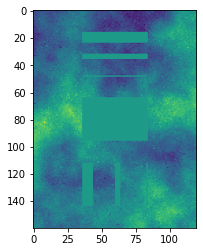

In [39]:
scale_vec = pyro.sample('scale', dist.Normal(torch.tensor(0.), torch.tensor(1.)).expand([prod(img.shape)]))
scale = torch.diag(F.softplus(scale_vec))
x = pyro.sample('x', dist.MultivariateNormal(img.reshape(-1), scale_tril=scale))
net = CNN(nlayers)
z = net(x.reshape(img.shape)) * mask
pyro.sample('z', dist.MultivariateNormal(z.reshape(-1), scale_tril=scale), obs=img)
z = np.squeeze(z.detach().numpy())
plt.imshow(z)

In [34]:
img.shape

torch.Size([160, 120])